# Convolutional Neural Network

In this notebook, we will strengthen the fundamental understanding of Convolutional Neural Network (CNN) by using built-in CNN architectures in Gluon.

Notice that, if you are running on GPU, please ensure you are using `mxnet-cu101mkl` >= 1.6.0 by running the following updating command.

In [1]:
! pip install -q -U mxnet-cu101mkl==1.6.0.post0
! pip install d2l

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


## 1. A Toy Example

Firstly, let's use the built-in CNN classes in Gluon with a toy example. Gluon has a variety of convolutional layers 
such as `nn.Conv1d()`, `nn.Conv2d()`, and more [here](https://beta.mxnet.io/api/gluon/nn.html#convolutional-layers). In the built-in classes, we can also add padding and stride. Recall that:

"padding" adds rows/columns around the input, 

![Padding.](https://d2l.ai/_images/conv-pad.svg)


while "stride" refers to the number of “unit” the kernel shifted per slide over rows/columns.

![Stride.](https://d2l.ai/_images/conv-stride.svg)


### 2D Convolution
Let's experiment an example with input shape of (8, 8), with a kernel size of 3, padding size of 1 and stride size of 2. The output shape of the `Conv2D()` should be:

\begin{align}
\text{ Output shape} & = \lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor \\
 & = \lfloor(8 - 3 + 1 + 2) / 2\rfloor \times \lfloor(8 - 3 + 1 + 2) / 2\rfloor \\
 & = (4, 4)
\end{align}

Let's validate in code! First, let's import the packages:

In [2]:
from mxnet import nd
from mxnet.gluon import nn

To check the output of the convolution layers, we define the `comp_conv2d` function as forward propogation.

In [3]:
def comp_conv2d(conv2d, X):
    conv2d.initialize()
    # Add batch and channel dimension.
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions
    return Y.reshape(Y.shape[2:])

Now we can verify the outpur shape of the Conv2D layer.

In [4]:
X = nd.random.uniform(shape=(8, 8))
conv2d = nn.Conv2D(channels=1, kernel_size=3, padding=1, strides=2)
comp_conv2d(conv2d, X).shape

(4, 4)

Let's try a slightly more complicated example with a input shape (8,8), with a kernel size of (3,5), padding size of (0,1) and stride size of (3, 4). The output shape of the `Conv2D()` should be:

\begin{align}
\text{ Output shape} & = \lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor \\
 & = \lfloor(8 - 3 + 0 + 3)/3\rfloor \times \lfloor(8 - 5 + 1 + 4)/4\rfloor \\
 & = (2, 2)
\end{align}

Let's validate in code! 

In [5]:
X = nd.random.uniform(shape=(8, 8))
conv2d = nn.Conv2D(1, kernel_size=(3, 5), padding=(0, 1), strides=(3, 4))
comp_conv2d(conv2d, X).shape

(2, 2)

### Pooling

Recall max pooling returns the maximal value in the pooling window, while average pooling summizes the means.

![Pooling.](https://d2l.ai/_images/pooling.svg)


We can also import built-in pooling layer from Gluon with Padding and Stride, such as `MaxPool2D()` or `AvgPool1D()`. See full list of built-in pooling archetectures [here](https://beta.mxnet.io/api/gluon/nn.html#pooling-layers).

In [6]:
X = nd.arange(16).reshape((1, 1, 4, 4))
print(X)
pool2d = nn.MaxPool2D(pool_size=3, padding=1, strides=2)
pool2d(X)



[[[[ 0.  1.  2.  3.]
   [ 4.  5.  6.  7.]
   [ 8.  9. 10. 11.]
   [12. 13. 14. 15.]]]]
<NDArray 1x1x4x4 @cpu(0)>



[[[[ 5.  7.]
   [13. 15.]]]]
<NDArray 1x1x2x2 @cpu(0)>

## 2. A Real-world Example - MINC

[MINC](http://opensurfaces.cs.cornell.edu/publications/minc/) is short for Materials in Context Database, provided by Cornell. __We will use a subset of this dataset with the following classes: brick, carpet, food, mirror, sky, water.__ It is well labeled and has a moderate size thus is perfect to be our example.


![MINC 2500 Examples.](https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/datasets/MINC-2500.png)


### Loading the datasets
First, let's load packages and define the paths for train, validation and test dataset. 

In [7]:
# import the datasets
import boto3
import os
from os import path
import pandas as pd
import zipfile

bucketname = 'mlu-courses-datalake' # replace with your bucket name
filename = 'MLA-CV/data/minc-2500.zip' # replace with your object key

pathname = '../../data/'
s3 = boto3.resource('s3')
if not path.exists("../../data/"):
    try:
        os.makedirs(pathname)
    except OSError:
        print ("Creation of the directory %s failed" % path)

s3.Bucket(bucketname).download_file(filename , '../../data/minc-2500.zip')

print ("Successfully created the directory %s " % path)

datazip = zipfile.ZipFile('../../data/minc-2500.zip')
datazip.extractall('../../data/')

Successfully created the directory <module 'posixpath' from '/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/posixpath.py'> 


In [8]:
!rm ../../data/minc-2500.zip

In [9]:
import os
from d2l import mxnet as d2l
import mxnet as mx
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss

path = '../../data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

In [10]:
os.path.join(path, 'test')

'../../data/minc-2500/test'

It is a good practice to see what does the dataset look like! Let's define the `show_images` function and see some sample images in MINC.

In [11]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

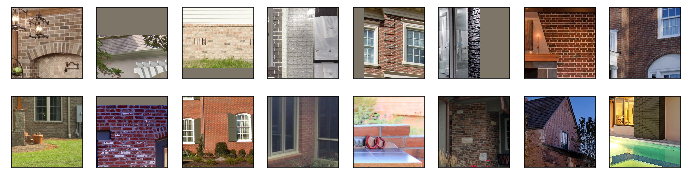

In [12]:
test_sample = gluon.data.DataLoader(gluon.data.vision.ImageFolderDataset(test_path),
                                    batch_size=2*8, shuffle=False)

for data, label in test_sample:
    show_images(data, 2, 8);
    break

To load the dataset properly, we need the massage the image data a bit by some `transfom` functions. First, we load the image data and resize it to the given size (224,224). Next, we convert the image NDArray of shape (H x W x C) in the range [0, 255] to a float32 tensor NDArray of shape (C x H x W) in the range (0, 1) using the `ToTensor` class. Last, we normalize an tensor of shape (C x H x W) with its mean and standard deviation by `Normalize`.

In [13]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

Now apply the predefined transform functions and load the train, validation and test sets.

In practice, reading data can be a significant performance bottleneck, especially when our model is simple or when our computer is fast. To make our life easier when reading from the datasets, we use a `DataLoader` of Gluon, which reads a minibatch of data with size `batch_size` each time.

In [14]:
batch_size = 16

train_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True)

validation_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False)

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False)

### Design the Network Architectures

Now it's the time to design the CNN neural networks! First, let's initailize a `Sequential` block. In Gluon, `Sequential` defines a container for several layers that will be chained together. Given input data, a `Sequential` passes it through the first layer, in turn passing the output as the second layer’s input and so forth.

We will build a neural netword with a 2D convolutional layer `Conv2D`, following by a 2D maxpooling layer `MaxPool2D`, a fully connected (or `Dense`) layer, and a final output `Dense` layer with output classes 23.

In [15]:
out_classes = 6

net = gluon.nn.Sequential()
net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))

# The Flatten layer collapses all axis, except the first one, into one axis.
net.add(gluon.nn.Flatten())
net.add(gluon.nn.Dense(128, activation='relu'))
net.add(gluon.nn.Dense(out_classes))

Our network is almost ready to be trained! One last thing before the training is to set up the hyperparameters, such training context `ctx` (GPU or CPU), the number of epochs to train, the learning rate of optimization algorithms. Besides, we specify the loss function. Since this problem is a multiclass classification task, we will use softmax as our loss funciton.

In [16]:
ctx = d2l.try_gpu() # Set this to CPU or GPU depending on your training instance

epochs = 10
learning_rate = 0.01
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

We can intialize the weights randomly by calling `initialize` in the predefined context `ctx`. 

To infer the neural network "how to optimize its weights", we instantiate the `Trainer`, which defines the parameters to optimize over (obtainable from our net via net.collect_params()), the optimization algorithm we wish to use (sgd), and a dictionary of hyperparameters required by our optimization algorithm. SGD just requires that we set the value learning_rate.

In [17]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

Now it's the training time! Starting with the outer loop, we will have 10 epochs (10 full pass through our dataset).

In [18]:
for epoch in range(epochs):
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_etropy_loss(output, label)
        loss.backward()
        train_acc += (output.argmax(axis=1) == label.astype('float32')).mean()
        train_loss += loss.mean()
        trainer.step(data.shape[0])
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        valid_acc += (output.argmax(axis=1) == label.astype('float32')).mean()
        val_loss += softmax_cross_etropy_loss(output, label).mean()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch, train_loss.asnumpy()[0], train_acc.asnumpy()[0], val_loss.asnumpy()[0], valid_acc.asnumpy()[0]))

Epoch 0: train loss 1.732, train acc 0.274, val loss 1.624, val acc 0.323
Epoch 1: train loss 1.549, train acc 0.353, val loss 1.582, val acc 0.318
Epoch 2: train loss 1.397, train acc 0.468, val loss 1.378, val acc 0.495
Epoch 3: train loss 1.293, train acc 0.529, val loss 1.339, val acc 0.464
Epoch 4: train loss 1.214, train acc 0.563, val loss 1.707, val acc 0.396
Epoch 5: train loss 1.030, train acc 0.622, val loss 1.337, val acc 0.490
Epoch 6: train loss 0.875, train acc 0.674, val loss 1.166, val acc 0.562
Epoch 7: train loss 0.777, train acc 0.749, val loss 1.139, val acc 0.609
Epoch 8: train loss 0.602, train acc 0.789, val loss 1.031, val acc 0.625
Epoch 9: train loss 0.476, train acc 0.853, val loss 1.291, val acc 0.599


As you may notice that the training loss and accurcay keep improving, while the validation loss and accuracy are fluctuated. This is a signal of overfitting, and we will show you more tricks about stable training in the following sessions!